<a href="https://colab.research.google.com/github/wherzberg/Nonlinear_PCA/blob/main/NLPCA_Test_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Principal Component Analysis

*   Billy Herzberg
*   william.herzberg@marquette.edu

This notebook will apply nonlinear principal component analysis (NLPCA) to an experimental data set regarding breast cancer diagnosis. Comparisons will be made to linear PCA. The data set is mostly linear so only small improvements are expected in NLPCA. Either can be used effectively to minimize the dimension of the data prior to a classification scheme.

In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Breat Cancer Data Set

The data set is provided by the SciKit-learn library and can be loaded in

In [32]:
# Load the data set
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print('Loaded data')

Loaded data


The data set is a common data set used for classification between benign and malignant tumors. There are 569 samples each with 30 factors and a classification; 357 samples are classified as benign (1) and the remaining are calssified as malignant (0).

In [33]:
# Pick out the predictors and classifier
X = data.data
Y = data.target
print(X.shape)
print(Y.shape)

(569, 30)
(569,)


In [34]:
# Divide the samples into a training and validation sets
split = 400
X_tr = X[     :split,:]
X_va = X[split:     ,:]
Y_tr = Y[     :split]
Y_va = Y[split:     ]
print(X_tr.shape)
print(X_va.shape)

(400, 30)
(169, 30)


# PCA

First, PCA can be used to reduce the dimension of the data

In [35]:
# Standardize the data
scaler = StandardScaler()
X_tr_cen = scaler.fit_transform(X_tr)
X_va_cen = scaler.transform(X_va)
print(np.mean(X_tr_cen,axis=0))

[-4.29684066e-15 -1.53044244e-15  2.83106871e-17 -1.99562589e-16
  3.89285826e-15 -4.32709424e-16 -2.23432384e-16  2.12135864e-15
  3.10810405e-15 -3.90201760e-15 -9.56734691e-16 -4.68514116e-16
  1.00239261e-15  7.59531327e-16 -2.09554596e-16 -3.28626015e-16
  1.24275590e-15 -6.92224056e-16 -2.97262215e-16  1.28008715e-15
  1.33948408e-15  2.33660313e-15 -2.27928787e-15  6.68354261e-16
 -2.34867681e-15 -3.88578059e-16 -2.18436380e-16 -3.06143999e-16
 -1.35336187e-15  1.31956945e-15]


(400, 30)
(169, 30)


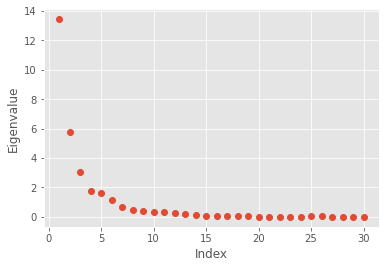

In [36]:
# Compute the projection matrix using eigenvalue decomposition
COV = np.cov(X_tr_cen.T)
vals, vecs = np.linalg.eig(COV)

# Compute the scores matrix for training and validation
T_tr = X_tr_cen @ vecs
T_va = X_va_cen @ vecs
print(T_tr.shape)
print(T_va.shape)

# Plot the eigenvalues
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(range(1,31),vals,'o')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.show()

In [37]:
# For each number of principal components, project back to X space
E_tr_pca = np.zeros((X[0,:].shape))
E_va_pca = E_tr_pca

for num_pcs in range(X.shape[1]):

    # Project to X space
    X_tr_prime_cen = T_tr[:,0:num_pcs] @ vecs[:,0:num_pcs].T
    X_va_prime_cen = T_va[:,0:num_pcs] @ vecs[:,0:num_pcs].T

    # Unscale
    X_tr_prime = scaler.inverse_transform(X_tr_prime_cen)
    X_va_prime = scaler.inverse_transform(X_va_prime_cen)

    # Determine the error between X and X_prime
    E_tr_pca[num_pcs] = np.mean( np.sqrt( np.sum( np.square( X_tr - X_tr_prime ), axis=1 ) ), axis=0 )
    E_va_pca[num_pcs] = np.mean( np.sqrt( np.sum( np.square( X_va - X_va_prime ), axis=1 ) ), axis=0 )
    

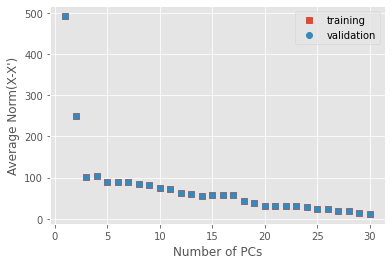

In [38]:
# Make a plot of the 2-norm errors for each number of PCs
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(range(1,31),E_tr_pca,'s')
    axs.plot(range(1,31),E_va_pca,'o')
    plt.xlabel('Number of PCs')
    plt.ylabel('Average Norm(X-X\')')
    axs.legend(['training','validation'])
    plt.show()

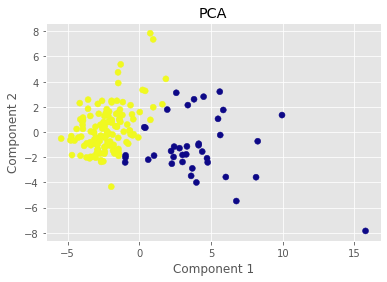

In [39]:
# Make a plot of first two components for PCA
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.scatter(T_va[:,0], T_va[:,1], c=Y_va,cmap='plasma')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('PCA')
    plt.show()

# NLPCA

Repeat using NLPCA

In [40]:
# To Perform NLPCA, Encoder/Deconder models will be trained.
# A different model will need to be used for each number of PCs
# Define some functions here to make it easier...

# Building a model
def buildModel( X, M1, M2, num_pcs, drop ):
    af   = 'tanh'           # Activation function for encoder/decoder hidden layers
    init = 'glorot_normal'  # Weight initializer

    input = tf.keras.layers.Input( shape=(X.shape[1]) )
    drop1   = tf.keras.layers.Dropout( rate = drop )(input)
    encoder = tf.keras.layers.Dense(         M1, activation = af,       kernel_initializer=init )(drop1)
    pc      = tf.keras.layers.Dense(          1, activation = 'linear', kernel_initializer=init )(encoder)
    drop2   = tf.keras.layers.Dropout( rate = drop )(pc)
    decoder = tf.keras.layers.Dense(         M2, activation = af,       kernel_initializer=init )(drop2)
    output  = tf.keras.layers.Dense( X.shape[1], activation = 'linear', kernel_initializer=init )(decoder)
    model   = tf.keras.Model(input,output)

    return model

# Train the model
def trainModel( model, X_tr, X_va, lr, bs, e, pat ):

    # First compile
    op = tf.keras.optimizers.Adam( learning_rate = lr )
    model.compile( optimizer = op, loss = 'mse' )

    # Then train
    hist = model.fit(
        x = X_tr,                       # input is X
        y = X_tr,                       # desired output is also X
        validation_data = (X_va, X_va),
        batch_size = bs,
        epochs     = e,
        verbose    = 0,
        callbacks = tf.keras.callbacks.EarlyStopping( patience = pat, restore_best_weights=True )
    )

    return model, hist

# Load weights into encoder and get score
def getScore( model, X_tr_cen, X_va_cen, M1 ):

    # Build the encoder only model
    af   = 'tanh'           # Activation function for encoder/decoder hidden layers
    init = 'glorot_normal'  # Weight initializer
    input = tf.keras.layers.Input( shape=(X.shape[1]) )
    encoder = tf.keras.layers.Dense(         M1, activation = af,       kernel_initializer=init )(input)
    pc      = tf.keras.layers.Dense(          1, activation = 'linear', kernel_initializer=init )(encoder)
    encoder_model = tf.keras.Model(input,pc)

    # Load the weights from the full model
    encoder_model.layers[1].set_weights(model.layers[2].get_weights())
    encoder_model.layers[2].set_weights(model.layers[3].get_weights())

    # Send the samples through to get the scores
    t_tr = encoder_model.predict(X_tr_cen).squeeze()
    t_va = encoder_model.predict(X_va_cen).squeeze()

    return t_tr, t_va

print("Done")

Done


In [41]:
# Maximum number of Factors to solve for
max_pcs = 10

# Get a new copy for iteration
xx_tr = X_tr
xx_va = X_va

# Setup storage matrices
X_tr_prime = np.zeros(X_tr.shape)
X_va_prime = np.zeros(X_va.shape)
T_tr_nlpca = np.zeros((X_tr.shape[0],max_pcs))
T_va_nlpca = np.zeros((X_va.shape[0],max_pcs))
E_tr_nlpca = np.zeros((max_pcs))
E_va_nlpca = np.zeros((max_pcs))

# For each number of principal components, train and predict
for num_pcs in range(max_pcs):

    # Center the data
    scaleri = StandardScaler()
    xx_tr_cen = scaleri.fit_transform(xx_tr)
    xx_va_cen = scaleri.transform(xx_va)

    # Decide parameters M1 and M2
    M1 = 10
    M2 = 10
    drop = 0.2

    # Build the model
    model = buildModel(xx_tr_cen, M1, M2, 1, drop)

    # Train the model
    lr  = 0.001
    bs  = 10
    e   = 10000
    pat = 50
    [model, hist] = trainModel( model, xx_tr_cen, xx_va_cen, lr, bs, e, pat )

    # Plot the training loss
    #with plt.style.context('ggplot'):
    #    fig, axs = plt.subplots(1,1)
    #    axs.plot(hist.history['loss'])
    #    axs.plot(hist.history['val_loss'])
    #    axs.set_ylim([0, 2])
    #    axs.legend(['training','validation'])
    #    plt.xlabel('Epoch')
    #    plt.ylabel('MSE')
    #    plt.title(num_pcs+1)
    #    plt.show()

    # Get the scores
    if num_pcs < max_pcs: # 3:
        [t_tr_i, t_va_i] = getScore( model, xx_tr_cen, xx_va_cen, M1 )
        T_tr_nlpca[:,num_pcs] = t_tr_i
        T_va_nlpca[:,num_pcs] = t_va_i

    # Project to X space and unscale
    xx_tr_prime_cen = model.predict(xx_tr_cen)
    xx_va_prime_cen = model.predict(xx_va_cen)
    xx_tr_prime = scaleri.inverse_transform(xx_tr_prime_cen)
    xx_va_prime = scaleri.inverse_transform(xx_va_prime_cen)
    X_tr_prime  = X_tr_prime + xx_tr_prime
    X_va_prime  = X_va_prime + xx_va_prime

    # Determine the error between X and X_prime
    E_tr_nlpca[num_pcs] = np.mean( np.sqrt( np.sum( np.square( X_tr - X_tr_prime ), axis=1 ) ), axis=0 )
    E_va_nlpca[num_pcs] = np.mean( np.sqrt( np.sum( np.square( X_va - X_va_prime ), axis=1 ) ), axis=0 )

    # Subtract the projection from X
    xx_tr = xx_tr - xx_tr_prime
    xx_va = xx_va - xx_va_prime

    # Display update
    print("Done with model for", num_pcs+1, "principal components (min val_mse=", round(np.min(hist.history["val_loss"]),4), ")")
    print(E_va_nlpca[num_pcs])

Done with model for 1 principal components (min val_mse= 0.4585 )
243.73388754979868
Done with model for 2 principal components (min val_mse= 0.6147 )
108.98814406360346
Done with model for 3 principal components (min val_mse= 0.7319 )
90.38666878203216
Done with model for 4 principal components (min val_mse= 0.8159 )
74.71100480615713
Done with model for 5 principal components (min val_mse= 0.8475 )
77.27402740090169
Done with model for 6 principal components (min val_mse= 0.8311 )
63.58756330872274
Done with model for 7 principal components (min val_mse= 0.8494 )
61.93224575593683
Done with model for 8 principal components (min val_mse= 0.95 )
60.02339942585813
Done with model for 9 principal components (min val_mse= 0.924 )
55.810043172248115
Done with model for 10 principal components (min val_mse= 1.0273 )
56.44921998053092


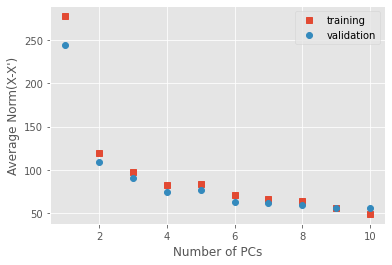

In [42]:
# Make a plot of the 2-norm errors for each number of PCs for NLPCA
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(range(1,11),E_tr_nlpca,'s')
    axs.plot(range(1,11),E_va_nlpca,'o')
    plt.xlabel('Number of PCs')
    plt.ylabel('Average Norm(X-X\')')
    axs.legend(['training','validation'])
    plt.show()

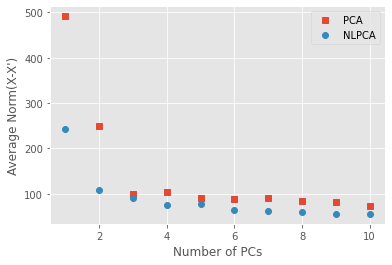

In [43]:
# Make a plot of the 2-norm errors for each number of PCs for both PCA and NLPCA
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(range(1,11),E_va_pca[:max_pcs],'s')
    axs.plot(range(1,11),E_va_nlpca,'o')
    plt.xlabel('Number of PCs')
    plt.ylabel('Average Norm(X-X\')')
    axs.legend(['PCA','NLPCA'])
    plt.show()

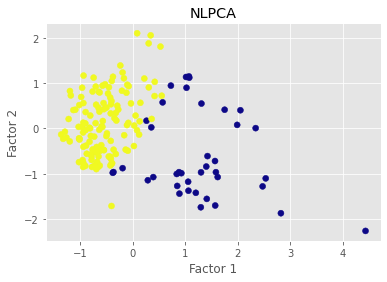

In [44]:
# Make a plot of first two scores for NLPCA
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.scatter(T_va_nlpca[:,0], T_va_nlpca[:,1], c=Y_va,cmap='plasma')
    plt.xlabel('Factor 1')
    plt.ylabel('Factor 2')
    plt.title('NLPCA')
    plt.show()